In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sns
import pandas as pd, numpy as np
import os, shutil, sys, subprocess
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, display_html

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 12,8
pd.set_option('display.float_format', '{:.3f}'.format)

sys.path.append('..')

# Exploration of inputs and network outputs

In [3]:
from tensorflow_models.base import Config

cfg = Config('kate.yaml')

print(str(cfg))

Using TensorFlow backend.
paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


alpha                    0.8
batch_size               32
batches_to_prefetch      30
callbacks                {                             'CustomModelCheckpoint': {                             'checkpoint_file': '/home/patrick/app/outputs/20190413_0943/model_checkpoint.ckpt',
                                                                                     'mode': 'auto',
                                                                                     'model': 'autoencoder',
                                                                                     'monitor': 'val_loss',
                                                                                     'save_best_only': True},
                              'EarlyStopping': {                             'min_delta': 1e-05,
                                                                             'monitor': 'val_loss',
                                                                             'patience': 5,
    

../tensorflow_models/base/config.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = parse_config(yaml.load(yaml))
../tensorflow_models/base/config.py:161: UserWarning: No check for callbacks
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for classification_loss
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for competitive_topk
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for competitive_type
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for encoder_dims
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for normalization
  warnings.warn("No check f

In [4]:
from tensorflow_models.data_loaders import load_newsgroups
from tensorflow_models.base import Config

cfg = Config('kate.yaml')


(X_train, y_train, _), (X_val, y_val, _), (X_test, y_test, _), tn = load_newsgroups(
    data_home=cfg.data_home,
    preprocessed_data=cfg.preprocessed_datasets,
    stopwords='../preprocessed_data/patterns/english_stopwords.txt',
#     categories=['alt.atheism', 'comp.graphics', 'rec.autos'],
    clean=True,
    stem=True,
    filters=['from_field', 'digits'],
    examples_per_class=.1,
    validation_split=cfg.validation_split,
    print_fn=None)

X_train.shape, y_train.shape

../tensorflow_models/base/config.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = parse_config(yaml.load(yaml))
../tensorflow_models/base/config.py:161: UserWarning: No check for callbacks
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for classification_loss
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for competitive_topk
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for competitive_type
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for encoder_dims
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:161: UserWarning: No check for normalization
  warnings.warn("No check f

## Inputs preprocessing

Vocabulary size: 14796 stopwords: 52109
New size: (9051, 14796)
['sharabl' 'xtmj' 'disparag' 'kunst' 'djurgarden' 'vorpal' 'stead' 'jkh'
 'wnder' 'punishn' 'vul' 'mcng' 'wielder' 'shorm' 'lorien' 'dilbar'
 'fertilz' 'roehm' 'spilt' 'desptr' 'urinalisi' 'thisto' 'tancredi' 'hkk'
 'jisx' 'helth' 'varnet' 'mcgovern' 'chryse' 'ntv' 'ieuc' 'vzngtlu'
 'znazzt' 'xappeal' 'qjz' 'skjegg' 'slobodan' 'stang' 'zyxelb'
 'harutunian' 'touchscreen' 'shiner' 'prag' 'xgsv' 'pasrg' 'xaz' 'lesb'
 'egna' 'wmqir' 'tfirst']


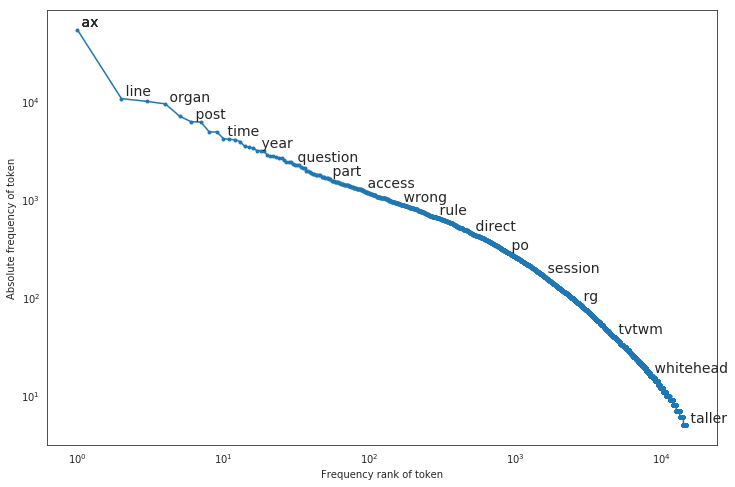

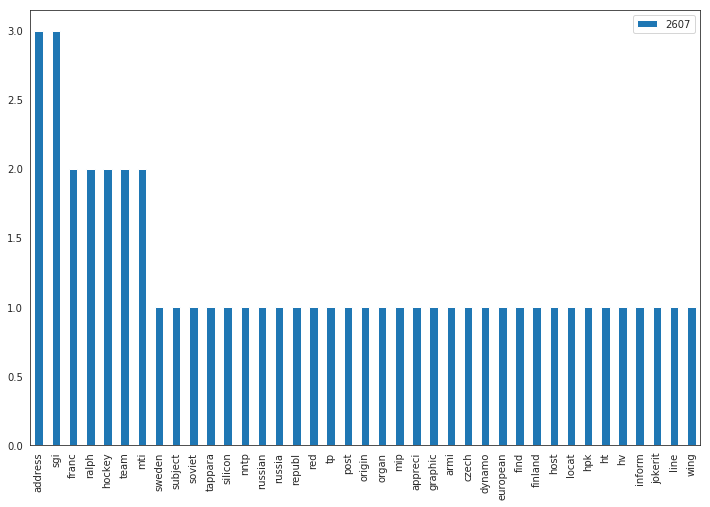

In [40]:
from tensorflow_models.utils.plotting import plot_zipf
from sklearn.feature_extraction.text import CountVectorizer

vect_options = {
#     'max_features': 10000,
    'min_df': 5,
#     'max_df': 0.5,
}

vect = CountVectorizer(**vect_options)
Xc = vect.fit_transform(X_train).toarray()

print('Vocabulary size: {} stopwords: {}'.format(len(vect.vocabulary_), len(vect.stop_words_)))
print('New size: {}'.format(Xc.shape))


def plot_zipf(X, vocab, ax=None):
    X = pd.DataFrame(X, columns=vocab)
    ranks = np.arange(1, len(vocab) + 1)
    counts = X.sum(axis=0).sort_values(ascending=False)
    indices = np.argsort(-X.sum(axis=0))
    ax = ax or plt.subplot()
    ax.loglog(ranks, counts, marker='.')
    ax.set_xlabel("Frequency rank of token")
    ax.set_ylabel("Absolute frequency of token")
    
    for n in list(np.logspace(-0.5, np.log10(len(vocab)), 20).astype(int)):
        _ = ax.text(ranks[n], counts[n], " " + vocab[indices[n]],
                    fontdict={'size': 14},
                    verticalalignment="bottom",
                    horizontalalignment="left")
    
    return counts

def get_unique_words(X, y, classes, vocab):
    series = {}
    for ci, c in enumerate(tn):
        docs = pd.DataFrame(Xc[y == ci], columns=vect.get_feature_names())
        counts = docs.sum(axis=0).sort_values(ascending=False)
        plt.loglog(np.arange(1, len(counts) + 1), counts, label=c)
        series[c] = counts[counts!=0]

    # plt.legend()

    for c, s in series.items():
        unique_words = set(s.index)
        for k, v in series.items():
            if k != c:
                unique_words -= set(v.index)
        print("{}: {}".format(c, len(unique_words)))
    #     display(s[unique_words].sort_values(ascending=False).head(10))
    
def plot_random_document(X, index=None, ax=None):
    df = pd.DataFrame(X, columns=vect.get_feature_names())
    if not index:
        sample = df.sample(1).T
    else:
        sample = df.iloc[[index]].T
    index = sample.columns[0]
    words = sample.where(sample[index] != 0).dropna().sort_values(index, ascending=False)
    ax = ax or plt.subplot()
    words.plot.bar(ax=ax)
    return index
    
print(np.random.choice(list(vect.stop_words_), 50, False))
plot_zipf(Xc, vect.get_feature_names());
random_index = plot_random_document(Xc)
# get_unique_words(Xc, y_train, tn, vect.get_feature_names())

## TfIdf transform

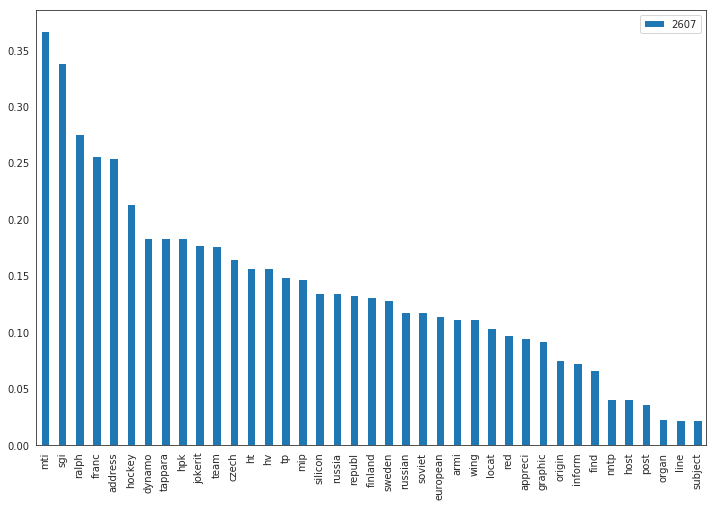

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xt = pd.DataFrame(tfidf.fit_transform(Xc).toarray(), columns=vect.get_feature_names())

plot_random_document(Xt, index=random_index);

## Grid search

In [47]:
from pprint import pprint
from time import time
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from tensorflow_models.utils.plotting import confusion_matrix


def make_pipeline(params=None, clf=True):
    steps = [('vect', CountVectorizer()), ('tfidf', TfidfTransformer())]
    if clf:
        steps.append(('clf', SGDClassifier()))
    pipeline = Pipeline(steps)
    if params:
        pipeline.set_params(**params)
    return pipeline

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__min_df': (1, 5, 0.01),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (5,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
}

def make_gridsearch(pipeline, parameters, training_data):
    grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(*training_data)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    df = pd.DataFrame(grid_search.cv_results_)
    with open('grid_search_results.pkl', 'wb') as f:
        pickle.dump(df, f)
        
    results = (df.sort_values('mean_test_score', ascending=False)
               .iloc[:20, 4:]
               .drop(['param_tfidf__use_idf', 
                      'params', 
                      'param_vect__min_df',
                      'rank_test_score'], axis=1)
               .drop([col for col in df.columns if col.startswith('param_clf')], axis=1)
               .drop([col for col in df.columns if col.startswith('split')], axis=1))
    return grid_search, best_parameters

def fit_classifier(pipeline, training_data, test_data):
    pipeline.fit(*training_data)
    X_test, y_test = test_data
    y_pred = pipeline.predict(X_test)
    eval_classifier(y_test, y_pred)
    return pipeline

def eval_classifier(y_true, y_pred):
    cr = classification_report(y_true, y_pred, target_names=tn)
    print(cr)
    confusion_matrix(y_true, y_pred, filename="tmp/confusion_matrix.png", classnames=tn)
    display_html('<img src="tmp/confusion_matrix.png?{}">'.format(np.random.randint(0, 2e9)), raw=True)
    

params = {
    'clf__alpha': 1e-06,
    'clf__max_iter': 20,
    'clf__penalty': 'elasticnet',
    'clf__tol': 1e-3, 
    'tfidf__norm': 'l1',
    'tfidf__use_idf': True,
    'vect__max_df': .75,
    'vect__max_features': None,
    'vect__min_df': 5
}

pipeline = make_pipeline(params)
fit_classifier(pipeline, (X_train[y_train != -1], y_train[y_train != -1]), (X_test, y_test))

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.59      0.57       319
           comp.graphics       0.53      0.62      0.57       389
 comp.os.ms-windows.misc       0.55      0.41      0.47       394
comp.sys.ibm.pc.hardware       0.46      0.55      0.50       392
   comp.sys.mac.hardware       0.53      0.65      0.58       385
          comp.windows.x       0.67      0.49      0.57       395
            misc.forsale       0.76      0.59      0.67       390
               rec.autos       0.66      0.75      0.70       396
         rec.motorcycles       0.73      0.82      0.77       398
      rec.sport.baseball       0.75      0.82      0.78       397
        rec.sport.hockey       0.88      0.81      0.84       399
               sci.crypt       0.87      0.78      0.82       396
         sci.electronics       0.48      0.52      0.50       393
                 sci.med       0.83      0.65      0.73       396
         

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Classifier weights

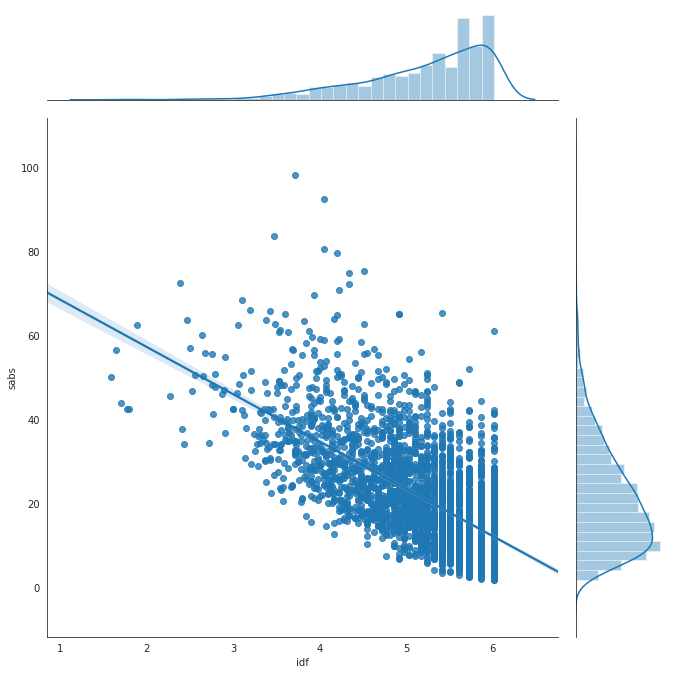

In [49]:
_, clf = pipeline.steps[-1]

features = pipeline.steps[0][1].get_feature_names()

def plot_idf_weights(idf_scores, weights, feature_names=None, target_names=None):
    metrics = ['sabs', 'ssq', 'mean', 'std', 'idf']
    feature_names = feature_names or np.arange(weights.shape[0])
    target_names = target_names or np.arange(weights.shape[1])
    coefs = pd.DataFrame(weights, index=feature_names, columns=target_names)
    coefs['mean'] = coefs[target_names].mean(axis=1)
    coefs['sabs'] = np.abs(coefs[target_names]).sum(axis=1)
    coefs['ssq'] = np.square(coefs[target_names]).sum(axis=1)
    coefs['std'] = coefs[target_names].std(axis=1)
    coefs['idf'] = idf_scores
    # coefs.loc[np.abs(coefs['sabs']) < 0.0001, ['sabs', 'ssq', 'mean', 'std', 'idf']].sort_values('mean', ascending=False)

    sns.jointplot(x='idf', y='sabs', data=coefs, kind='reg')
    plt.gcf().set_size_inches(10, 10)
    # ax.set_yscale('log')
    # coefs.loc[coefs['idf'] > 9, metrics].sort_values('ssq', ascending=False)
    # sns.boxplot(coefs.loc[coefs['ssq'] == 0, 'idf'])
    # sns.boxplot(coefs.loc[coefs['idf'] > 9, 'ssq'])
    
plot_idf_weights(pipeline.steps[1][1].idf_, clf.coef_.T, features, tn)

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

def clear():
    K.clear_session()
    shutil.rmtree('tmp/logs', ignore_errors=True)
    subprocess.call(['killall', 'tensorboard'])
    subprocess.Popen(['/home/quent/bin/anaconda3/envs/tensorflow/bin/tensorboard', '--logdir', 'tmp/logs'])
    
def build_mlp(layers, input_shape, activation=None, n_outputs=20):
    clear()
    model = Sequential(
        [Dense(units, activation=activation) for units in layers]
        + [Dense(n_outputs, activation='softmax')]
    )
    model.build(input_shape)
    return model

def fit_model(model, training_data, validation_data, epochs, batch_size, optimizer='adam', loss='categorical_crossentropy'):
    model.compile(optimizer=optimizer, loss=loss)
    
    history = model.fit(
        *training_data, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=validation_data, 
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, min_lr=0.0001), 
                   TensorBoard(log_dir='tmp/logs', histogram_freq=1)],
        verbose=0)
    
    return history

def eval_model(model, test_data):
    X_test, y_test = test_data
    y_pred = model.predict(X_test).argmax(axis=1)
    eval_classifier(y_test, y_pred)
    
    
n_features = len(features)
pipeline = make_pipeline(params={k: v for k, v in params.items() if not k.startswith('clf')}, clf=False)
Xt, yt = pipeline.fit_transform(X_train[y_train != -1]).toarray(), to_categorical(y_train[y_train != -1], 20)
Xv, yv = pipeline.transform(X_val).toarray(), to_categorical(y_val, 20)
model = build_mlp([128], (None, n_features))
optimizer = optimizers.get('adam').from_config({'lr': 0.001})
history = fit_model(model, (Xt, yt), (Xv, yv), 1000, 32, optimizer=optimizer)
eval_model(model, (pipeline.transform(X_test).toarray(), y_test))

                          precision    recall  f1-score   support

             alt.atheism       0.63      0.57      0.60       319
           comp.graphics       0.54      0.62      0.58       389
 comp.os.ms-windows.misc       0.60      0.48      0.54       394
comp.sys.ibm.pc.hardware       0.49      0.60      0.54       392
   comp.sys.mac.hardware       0.58      0.63      0.60       385
          comp.windows.x       0.65      0.58      0.61       395
            misc.forsale       0.70      0.63      0.66       390
               rec.autos       0.66      0.79      0.72       396
         rec.motorcycles       0.82      0.79      0.80       398
      rec.sport.baseball       0.81      0.78      0.80       397
        rec.sport.hockey       0.85      0.89      0.87       399
               sci.crypt       0.86      0.83      0.85       396
         sci.electronics       0.58      0.52      0.55       393
                 sci.med       0.73      0.70      0.72       396
         

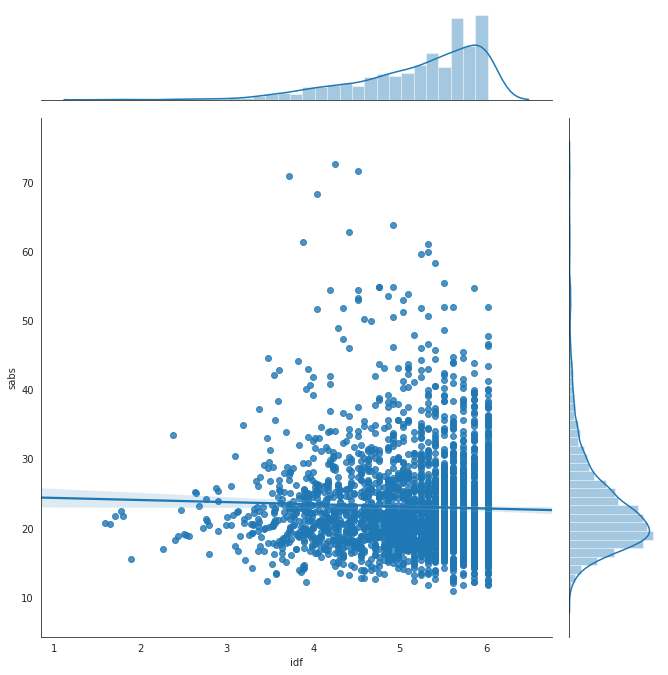

In [52]:
hidden, out = model.layers
w_h, b_h = hidden.get_weights()
w_o, b_h = out.get_weights()
plot_idf_weights(pipeline.steps[1][1].idf_, w_h, pipeline.steps[0][1].get_feature_names())
# hist = history.history
# plt.plot(np.arange(len(hist['loss'])), hist['loss'], label='train')
# plt.plot(np.arange(len(hist['val_loss'])), hist['val_loss'], label='val')
# plt.legend();

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Input, Flatten, Reshape

def build_model(filters, kernel_sizes, pool_sizes, input_shape, activation=None, n_outputs=20):
    X = Input(shape=input_shape)
    layer = Reshape((-1, X.shape[1], 1))(X)
    for nf, ks, ps in zip(filters, kernel_sizes, pool_sizes):
        layer = Conv1D(nf, ks, padding='same')(layer)
        layer = MaxPool1D(ps)(layer)
    
    layer = Flatten()(layer)
    y = Dense(n_outputs, activation='softmax')(layer)

    return Model(inputs=X, outputs=y)



# preprocessors = Pipeline(pipeline.steps[:2])
# X_train = preprocessors.fit_transform(X_train)
# X_val = preprocessors.transform(X_val)
# X_test = preprocessors.transform(X_test)

n_features = X_train.shape[1]
model = build_model([32, 64, 128], [4, 4, 4], [4, 4, 4], (n_features,), activation='relu')
# history = fit_model()

## Transformed inputs

In [ ]:
from tensorflow_models.data_loaders import TfIdfGenerator, load_newsgroups, Generator
from tensorflow_models.base import Config

cfg = Config('kate.yaml', {'output_dir': 'notebooks/tmp', 'examples_per_class': 1.})
generator = TfIdfGenerator(load_newsgroups, cfg)

X, y, _ = generator.train
target_names = generator.target_names
X = pd.DataFrame(X, columns=generator.vectorizer.vocabulary_)

In [ ]:
grouped = X.groupby(y).mean()
grouped.index = target_names

In [ ]:
grouped.loc[np.random.choice(target_names, 1)[0]].T.sort_values(ascending=False).head(20)

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_df=cfg.max_df, min_df=cfg.min_df, max_features=cfg.tokenizer_options['num_words'])
X_vect = pd.DataFrame(vect.fit_transform(X).toarray(), columns=vect.vocabulary_)
X_vect.shape

grouped = X_vect.groupby(y).mean()
grouped.index = target_names